# 1. Settings

## 1.1 User variables

In [1]:
from config import *

NB_RUNS = 30

TARGETS = [TARGET]
HEURISTICS = ["try_all_atoms", "max_coverage_static"] #["max_coverage_static"] #["try_all_atoms", "max_coverage_dynamic", "max_coverage_static", "max_diversity"]
THREADS = 8
USE_NAN = True

DATA_PATH = "tmp/data_discrete.csv"

# 1.2 Dev variables

In [2]:
RANDOM_SEED = 0

INPUT_DATA_DISCRETE = "tmp/data_discrete.csv"
OUTPUT_CSV = "tmp/lfit_output.csv"

VERBOSE = True

## 1.3 Imports

In [3]:
import pandas as pd
import numpy
import random
import pylfit
import os

random.seed(RANDOM_SEED)
numpy.random.seed(RANDOM_SEED)

## 1.4 Constants

In [4]:
# Constants
DEBUG = False

# 2. Data Loading

# DEBUG

In [5]:
# DEBUG
print("Training dataset:")
df = pd.read_csv(DATA_PATH)
cols = [c for c in df.columns if c not in TARGETS]

display(df)

for target in TARGETS:
    for val in df[target].unique():
        print(val,len(df[df[target] == val]))

Training dataset:


,M15,Juniperus,Larix,Picea,Pinus,Alnus,Betula,Fraxinus,Populus,Quercus,...,Ambrosia,Artemesia,Asteraceae,Chenopodiaceae,Cyperaceae,Myrica,Poaceae,Typha,Aquatics,Poaceae_prev
0,-1,-1,1,1,-1,1,-1,1,-1,1,...,-1,1,1,1,-1,1,1,1,0,0
1,1,-1,-1,-1,1,1,1,-1,1,-1,...,1,-1,1,-1,1,-1,-1,-1,0,0
2,-1,1,-1,1,1,-1,-1,1,1,-1,...,1,-1,1,-1,1,-1,-1,1,0,0
3,-1,1,1,-1,-1,1,1,-1,0,1,...,-1,1,0,1,1,1,-1,0,0,0
4,1,0,1,1,-1,-1,-1,1,-1,1,...,-1,-1,-1,-1,-1,-1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,1,-1,-1,-1,1,0,-1,-1,-1,-1,...,-1,-1,1,1,1,1,-1,-1,0,0
57,-1,-1,1,1,-1,1,1,1,1,1,...,1,1,0,-1,1,-1,-1,1,-1,1
58,1,-1,1,1,-1,-1,1,0,1,-1,...,-1,-1,0,-1,-1,1,1,1,1,1
59,-1,1,-1,-1,1,1,1,-1,-1,-1,...,1,1,0,1,-1,1,1,-1,-1,1


1 30
-1 31


In [6]:
# Load training dataset
cols = [c for c in df.columns if c not in list(df.select_dtypes(exclude=["number"]).columns)]
df[cols] = df[cols].astype('Int64')
df[cols] = df[cols].astype('string')

if not USE_NAN:
    df = df.dropna()
else:
    df = df.fillna("?")

col_order = list(df.columns)

df_output = pd.DataFrame(columns=["head_variable", "head_value", "body", "rule_size"])

for run_id in range(NB_RUNS):
    # Shuffle variables
    random.shuffle(col_order)
    df = df[col_order]

    FEATURES = [c for c in df.columns if c not in TARGETS]

    df.to_csv("tmp/lfit_input.csv")

    # Convert array data as a DiscreteStateTransitionsDataset using pylfit.preprocessing
    dataset = pylfit.preprocessing.discrete_state_transitions_dataset_from_csv(path="tmp/lfit_input.csv", \
    feature_names=FEATURES, target_names=TARGETS,unknown_values=["?"])

    # Initialize a DMVLP with the dataset variables and set GULA as learning algorithm
    model = pylfit.models.DMVLP(features=dataset.features, targets=dataset.targets)
    model.compile(algorithm="pride") # model.compile(algorithm="pride")
    model.fit(dataset=dataset, options={"heuristics":HEURISTICS, "verbose":0, "threads":THREADS})

    # Save rules
    rules_data = []

    for r in model.rules:
        body = ""
        for i in sorted(list(r.body.items())):
            body += i[1].to_string() + ", "
        if (len(body)>0):
            body = body[:-2]
        rules_data.append([r.head.variable, r.head.value, body, r.size(),r]) #, r.to_string()])

    df_rules = pd.DataFrame(rules_data, columns=["head_variable", "head_value", "body", "rule_size","raw_rule"]) #, "rule_raw_form"])

    nb_rules_of_run = len(df_rules)
    nb_rules_total_before = len(df_output)

    df_output = pd.concat([df_output,df_rules]).reset_index(drop=True)
    df_output.drop_duplicates(subset=["head_variable", "head_value", "body", "rule_size"], inplace=True)

    nb_new_rules = len(df_output) - nb_rules_total_before
    nb_duplicate_rules = nb_rules_of_run - nb_new_rules
    
    print("Run",str(run_id+1)+"/"+str(NB_RUNS),"- new rules found:", nb_new_rules, "- total:",len(df_output),"- duplicate:",nb_duplicate_rules)

    df_output.to_csv(OUTPUT_CSV,index=False)

display(df_output)


Run 1/30 - new rules found: 181 - total: 181 - duplicate: 0
Run 2/30 - new rules found: 133 - total: 314 - duplicate: 95
Run 3/30 - new rules found: 79 - total: 393 - duplicate: 87
Run 4/30 - new rules found: 25 - total: 418 - duplicate: 103
Run 5/30 - new rules found: 67 - total: 485 - duplicate: 136
Run 6/30 - new rules found: 83 - total: 568 - duplicate: 92
Run 7/30 - new rules found: 39 - total: 607 - duplicate: 157
Run 8/30 - new rules found: 25 - total: 632 - duplicate: 122
Run 9/30 - new rules found: 23 - total: 655 - duplicate: 118
Run 10/30 - new rules found: 12 - total: 667 - duplicate: 153
Run 11/30 - new rules found: 15 - total: 682 - duplicate: 184
Run 12/30 - new rules found: 32 - total: 714 - duplicate: 146
Run 13/30 - new rules found: 24 - total: 738 - duplicate: 158
Run 14/30 - new rules found: 9 - total: 747 - duplicate: 199
Run 15/30 - new rules found: 24 - total: 771 - duplicate: 169
Run 16/30 - new rules found: 20 - total: 791 - duplicate: 159
Run 17/30 - new rules

,head_variable,head_value,body,rule_size,raw_rule
0,Poaceae,-1,"Cyperaceae(1), Juniperus(-1), M15(1), Pinus(1)",4,"Poaceae(-1) :- Cyperaceae(1), Juniperus(-1), M..."
1,Poaceae,-1,"Chenopodiaceae(1), Cyperaceae(1), Larix(-1)",3,"Poaceae(-1) :- Chenopodiaceae(1), Cyperaceae(1..."
2,Poaceae,-1,"Cyperaceae(1), M15(1), Pinus(1), Ulmus(-1)",4,"Poaceae(-1) :- Cyperaceae(1), M15(1), Pinus(1)..."
3,Poaceae,-1,"Chenopodiaceae(1), Cyperaceae(1), M15(1), Pinu...",4,"Poaceae(-1) :- Chenopodiaceae(1), Cyperaceae(1..."
4,Poaceae,-1,"Cyperaceae(1), M15(1), Pinus(1), Populus(-1)",4,"Poaceae(-1) :- Cyperaceae(1), M15(1), Pinus(1)..."
...,...,...,...,...,...
966,Poaceae,-1,"Artemesia(-1), Larix(1), Picea(-1)",3,"Poaceae(-1) :- Artemesia(-1), Larix(1), Picea(..."
968,Poaceae,-1,"Aquatics(-1), Artemesia(-1), Larix(1), Pinus(1)",4,"Poaceae(-1) :- Aquatics(-1), Artemesia(-1), La..."
971,Poaceae,-1,"Artemesia(-1), Larix(1), Pinus(1), Quercus(-1)",4,"Poaceae(-1) :- Artemesia(-1), Larix(1), Pinus(..."
1061,Poaceae,1,"Juniperus(0), Quercus(1), Typha(1)",3,"Poaceae(1) :- Juniperus(0), Quercus(1), Typha(1)."


# Evaluation

In [7]:
def score_rule(rule,df):
    true_pos = 0
    false_pos = 0
    unknown_true_pos = 0
    unknown_false_pos = 0

    for idx, row in df.iterrows():
        matches = "FULL"
        for (var,val) in rule.body.items():
            if (str(row[var]) != "?"):
                if (str(row[var]) != str(val.value)):
                    matches = "NO"
                    break
            else:
                matches = "PARTIAL"

        if matches == "FULL":
            if str(row[rule.head.variable]) == str(rule.head.value):
                true_pos += 1
            else:
                false_pos += 1
        elif matches == "PARTIAL":
            if str(row[rule.head.variable]) == str(rule.head.value):
                unknown_true_pos += 1
            else:
                unknown_false_pos += 1

    if (true_pos + false_pos) == 0:
        accuracy = 0
    else:
        accuracy = true_pos / (true_pos + false_pos)

    if (true_pos + unknown_false_pos) == 0:
        unknown_accuracy = 0
    else:
        unknown_accuracy = true_pos / (true_pos + unknown_false_pos)

    return true_pos, false_pos, accuracy, unknown_true_pos, unknown_false_pos, unknown_accuracy

In [8]:
TRAINING_DATASET = INPUT_DATA_DISCRETE
TEST_DATASET = None

for dataset, state  in [(TRAINING_DATASET, "train"), (TEST_DATASET, "test")]:
    if dataset is None:
        break
    #print("Evaluation of rules on",state,":",dataset)
    true_pos = []
    false_pos = []
    accuracy = []
    unknown_true_pos = []
    unknown_false_pos = []
    unknown_accuracy = []

    df = pd.read_csv(dataset)
    cols = [c for c in df.columns if c not in list(df.select_dtypes(exclude=["number"]).columns)]
    df[cols] = df[cols].astype('Int64')
    df[cols] = df[cols].astype('string')
    if not USE_NAN:
        df = df.dropna()
    else:
        df = df.fillna("?")

    for idx, row in df_output.iterrows():
        tp, fp, acc, utp, ufp, uacc = score_rule(row["raw_rule"], df)
        true_pos += [tp]
        false_pos += [fp]
        accuracy += [acc]
        unknown_true_pos += [utp]
        unknown_false_pos += [ufp]
        unknown_accuracy += [uacc]
        print("\r",str(idx+1)+"/"+str(len(df_output)),end="")

    df_output["support"] = true_pos
    #df_output["false_positives"] = false_pos
    #df_output["accuracy"] = accuracy
    #df_output["unknown_true_positives"] = unknown_true_pos
    #df_output["unknown_false_positives"] = unknown_false_pos
    #df_output["unknown_accuracy"] = unknown_accuracy
    print()


df_output = df_output.sort_values(["support"],ascending=False)
df_output.drop(["raw_rule"], axis=1,inplace=True)

df_output = df_output.drop_duplicates()
df_output.to_csv(OUTPUT_CSV,index=False)

display(df_output[df_output["head_value"] == "1"])

display(df_output[df_output["head_value"] == "-1"])

 1067/928


,head_variable,head_value,body,rule_size,support
259,Poaceae,1,"Ambrosia(-1), Picea(1), Ulmus(1)",3,8
145,Poaceae,1,"Juniperus(-1), Ulmus(1)",2,7
869,Poaceae,1,"Betula(-1), Larix(0)",2,7
382,Poaceae,1,"Artemesia(-1), Fraxinus(1), M15(1)",3,7
648,Poaceae,1,"Alnus(1), Betula(-1), Poaceae_prev(1), Populus(1)",4,6
...,...,...,...,...,...
114,Poaceae,1,"Alnus(1), Betula(1), M15(-1), Pinus(1)",4,1
483,Poaceae,1,"Ambrosia(1), Asteraceae(1), Myrica(1), Picea(-...",5,1
482,Poaceae,1,"Ambrosia(1), Myrica(1), Populus(1), Ulmus(-1)",4,1
112,Poaceae,1,"Betula(1), Chenopodiaceae(1), Pinus(1), Ulmus(-1)",4,1


,head_variable,head_value,body,rule_size,support
50,Poaceae,-1,"Ambrosia(1), Poaceae_prev(0)",2,10
52,Poaceae,-1,"Alnus(-1), Ambrosia(1), Picea(1)",3,9
67,Poaceae,-1,"Betula(1), Poaceae_prev(0)",2,9
18,Poaceae,-1,"Alnus(-1), Ambrosia(1), Larix(1)",3,8
219,Poaceae,-1,"Asteraceae(1), M15(1), Quercus(-1)",3,8
...,...,...,...,...,...
748,Poaceae,-1,"Pinus(1), Ulmus(0)",2,1
749,Poaceae,-1,"Betula(1), M15(1), Pinus(1), Salix(-1)",4,1
752,Poaceae,-1,"Ambrosia(-1), Chenopodiaceae(1), M15(1), Pinus(1)",4,1
491,Poaceae,-1,"Cyperaceae(1), Myrica(0), Pinus(1)",3,1


# Influence Graph extraction

In [9]:
total_rules = len(df_output)
print("Total rules:", total_rules)
df_tmp = df_output[df_output["support"] >= MIN_SUPPORT]
print("With min support", len(df_tmp))

df_up = df_tmp[df_tmp["head_value"] == "1"]
df_down = df_tmp[df_tmp["head_value"] == "-1"]
display(df_up)
display(df_down)

influences = {c:{-1:0,1:0} for c in df.columns}

for (df_tmp, influence_type) in [(df_up, 1),(df_down, -1)]:
    for idx, row in df_tmp.iterrows():
        body = row["body"].split(",")
        body = [i.strip().strip(")").split("(") for i in body]
        #print(influence_type, body, row["support"])

        for var, value in body:
            if value == "1":
                #print(var,"influence",influence_type*int(round(row["support"]/row["rule_size"])))
                influences[var][influence_type] += int(round(row["support"]/row["rule_size"]))
            if value == "-1":
                #print(var,"influence",-influence_type*int(round(row["support"]/row["rule_size"])))
                influences[var][-influence_type] += int(round(row["support"]/row["rule_size"]))

data = []
for var in influences:
    data += [[var, influences[var][-1], influences[var][1]]]

df_influences = pd.DataFrame(data, columns=["Feature","positive_influence","negative_influence"])
df_influences["influence"] = df_influences["positive_influence"] - df_influences["negative_influence"]
df_influences = df_influences.sort_values(by=["influence"],ascending=False)
display(df_influences)

Total rules: 928
With min support 101


,head_variable,head_value,body,rule_size,support
259,Poaceae,1,"Ambrosia(-1), Picea(1), Ulmus(1)",3,8
145,Poaceae,1,"Juniperus(-1), Ulmus(1)",2,7
869,Poaceae,1,"Betula(-1), Larix(0)",2,7
382,Poaceae,1,"Artemesia(-1), Fraxinus(1), M15(1)",3,7
648,Poaceae,1,"Alnus(1), Betula(-1), Poaceae_prev(1), Populus(1)",4,6
646,Poaceae,1,"Artemesia(-1), Pinus(1), Poaceae_prev(1), Popu...",4,6
451,Poaceae,1,"Betula(1), Poaceae_prev(2), Ulmus(1)",3,6
836,Poaceae,1,"Ambrosia(-1), Fraxinus(1), M15(1)",3,6
242,Poaceae,1,"Alnus(1), Cyperaceae(-1), Picea(1)",3,6
556,Poaceae,1,"Chenopodiaceae(-1), Fraxinus(1), M15(1)",3,6


,head_variable,head_value,body,rule_size,support
50,Poaceae,-1,"Ambrosia(1), Poaceae_prev(0)",2,10
52,Poaceae,-1,"Alnus(-1), Ambrosia(1), Picea(1)",3,9
67,Poaceae,-1,"Betula(1), Poaceae_prev(0)",2,9
18,Poaceae,-1,"Alnus(-1), Ambrosia(1), Larix(1)",3,8
219,Poaceae,-1,"Asteraceae(1), M15(1), Quercus(-1)",3,8
...,...,...,...,...,...
397,Poaceae,-1,"Ambrosia(1), Larix(1), Typha(1)",3,5
27,Poaceae,-1,"Ambrosia(1), Betula(-1), Larix(1)",3,5
26,Poaceae,-1,"Ambrosia(1), Aquatics(0), Pinus(1)",3,5
25,Poaceae,-1,"Ambrosia(1), Larix(1), Pinus(1)",3,5


,Feature,positive_influence,negative_influence,influence
12,Ambrosia,72,4,68
2,Larix,44,0,44
16,Cyperaceae,29,2,27
3,Picea,32,8,24
6,Betula,28,4,24
13,Artemesia,25,3,22
14,Asteraceae,21,0,21
10,Salix,21,5,16
4,Pinus,18,4,14
17,Myrica,14,2,12


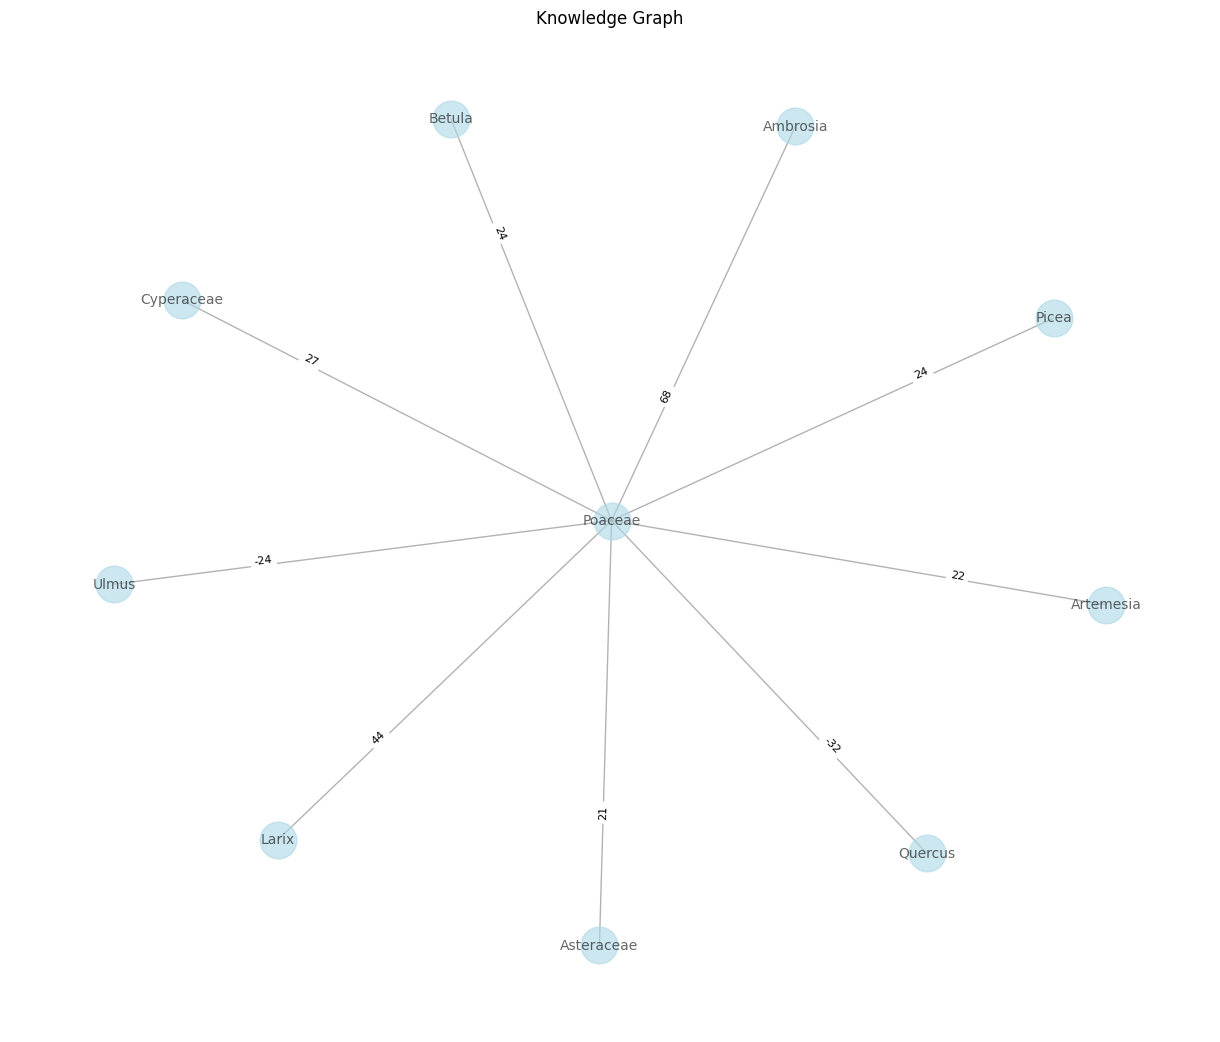

In [19]:
import networkx as nx
import matplotlib.pyplot as plt

MIN_INFLUENCE = 20

# Create a knowledge graph
G = nx.Graph()
for _, row in df_influences.iterrows():
    if abs(row["influence"]) >= MIN_INFLUENCE:
        G.add_edge(row['Feature'], TARGET, label=row['influence'])

# Visualize the knowledge graph
pos = nx.spring_layout(G, seed=42, k=0.9)
labels = nx.get_edge_attributes(G, 'label')
plt.figure(figsize=(12, 10))
nx.draw(G, pos, with_labels=True, font_size=10, node_size=700, node_color='lightblue', edge_color='gray', alpha=0.6)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8, label_pos=0.3, verticalalignment='baseline')
plt.title('Knowledge Graph')
plt.show()

# TODO